In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()
import pack_cuda_lut
pack_cuda_lut.USE_TEXTURE = True
pack_cuda_lut._initialized = False  # Force recompile with new code


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 8.443 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info  

In [2]:
N=1000
x_vals = np.linspace(-1., 1., N)
y_vals = np.linspace(-1., 1., N)

xyt = cp.array([[[0.,0.,0.],[x, y, 0.]] for x in x_vals for y in y_vals], dtype=kgs.dtype_cp)
xyt.shape

sol = kgs.SolutionCollectionSquare()
sol.xyt = xyt
sol.h = cp.array([[1.,0.,0.] for _ in range(xyt.shape[0])], dtype=kgs.dtype_cp)
sol.check_constraints()

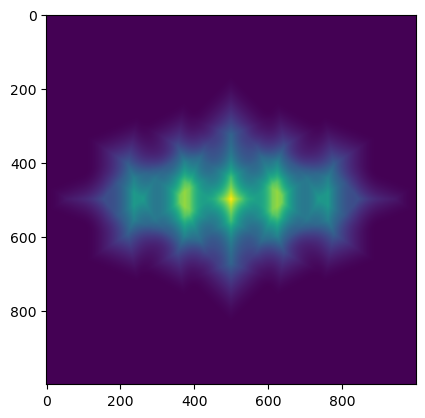

In [3]:
cost1 = pack_cost.CollisionCostSeparation().compute_cost_allocate(sol)[0].get()
cost1 = cost1.reshape((N, N))
plt.imshow(cost1)

Building lookup table for CollisionCostSeparation...
Building LUT: 5 x 5 x 5 = 125 grid points
  Processing theta 1/5
Cost range: [0.000000, 0.200776]
Trimming zero edges:
  X: 5 -> 5 (removed 0)
  Y: 5 -> 5 (removed 0)
  Theta: 5 -> 5 (removed 0)
  Total reduction: 0.0% (0 points)
Compiling CUDA LUT kernel (USE_TEXTURE=True, one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:4577,
                 from /usr/local/cuda/

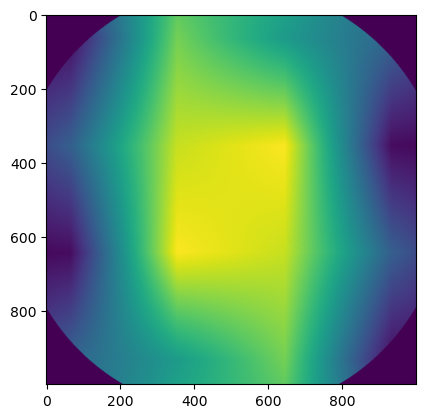

In [ ]:
cost_x = pack_cost.CollisionCostSeparation()
cost_x.use_lookup_table = True
cost_x.lut_N_x = 5
cost_x.lut_N_y = 5
cost_x.lut_N_theta = 5
cost2 = cost_x.compute_cost_allocate(sol)[0].get()
cost2 = cost2.reshape((N, N))
plt.imshow(cost2)

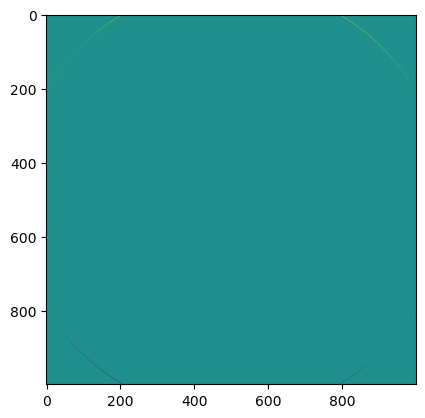

In [5]:
cost2_grad_x = np.diff(cost2, axis=0, prepend=cost2[0:1,:]) / (x_vals[1]-x_vals[0])
plt.imshow(cost2_grad_x)

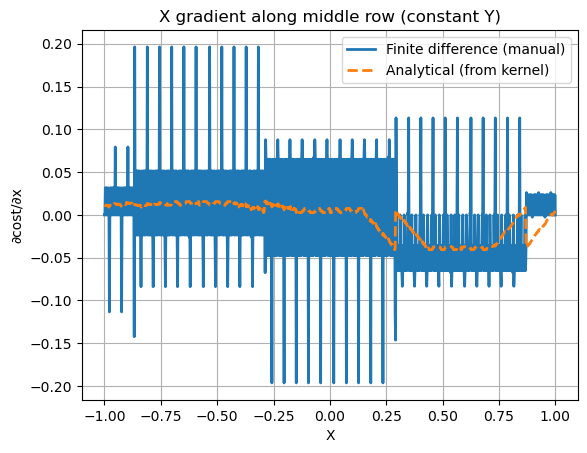

In [6]:
# Get gradient from cost function
_, grad_analytical, _ = cost_x.compute_cost_allocate(sol, evaluate_gradient=True)
grad_analytical_np = grad_analytical.get().reshape((N, N, 2, 3))
# grad_analytical_np has shape (N, N, 2 trees, 3 coords)
# We want gradient for tree 1 (index 1), x coordinate (index 0)
grad_x_analytical = grad_analytical_np[:, :, 1, 0]

row_idx = 331  # middle row
plt.plot(x_vals, cost2_grad_x[:,row_idx], label='Finite difference (manual)', linewidth=2)
plt.plot(x_vals, grad_x_analytical[:,row_idx], label='Analytical (from kernel)', linestyle='--', linewidth=2)
plt.xlabel('X')
plt.ylabel('∂cost/∂x')
plt.title('X gradient along middle row (constant Y)')
plt.grid(True)
plt.legend()

In [7]:
# Debug: Check LUT array shape and texture dimensions
print(f"LUT vals shape: {cost_x._lut.vals.shape}")
print(f"LUT texture_array: {cost_x._lut.texture_array}")
if cost_x._lut.texture_array:
    # Try to get texture dimensions
    print(f"Texture array width: {cost_x._lut.texture_array.width}")
    print(f"Texture array height: {cost_x._lut.texture_array.height}")
    print(f"Texture array depth: {cost_x._lut.texture_array.depth}")

LUT vals shape: (5, 5, 5)
LUT texture_array: <cupy.cuda.texture.CUDAarray object at 0x761a868209a0>
Texture array width: 5
Texture array height: 5
Texture array depth: 5
